# Starling Task across subject behavioral data analysis
Let's start the analysis based on Rhiannon's list [here](https://uofutah-my.sharepoint.com/:w:/g/personal/u1363968_umail_utah_edu/ESn4E7plikFIs1ZyLHy5YaUBZfn_td7fv2yCh6I5HsWL2g?e=MxDJfG&CID=0428038a-a81f-6b6f-5c00-c8f4ada097eb).

By: Niloufar Shahdoust

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns 
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FixedLocator

## functions:

### bar plot function for the blocks

In [2]:
def plot_with_error_bars(data, y_column_mean, y_column_std, x_labels, title, y_label, colors, annotation_offset, output_folder, file_name):
    fig, ax = plt.subplots(dpi=130, figsize=(4, 4))
    
    bars = ax.bar(data['block_type'], data[y_column_mean], color=colors,
                  yerr=data[y_column_std], capsize=5, width=0.5)
    
    ax.grid(False)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.set_xticks([bar.get_x() + bar.get_width() / 2 for bar in bars])
    ax.set_xticklabels(x_labels)

    max_y = data[y_column_mean].max() + data[y_column_std].max()
    if max_y < 1:
        max_y =1
    ax.set_ylim(0, max_y)
    ax.set_ylabel(y_label)


    plt.xlabel('block')
    plt.title(title)
    plt.savefig(os.path.join(output_folder, file_name), format="pdf", dpi=300, bbox_inches="tight")
    plt.show()

# ****************************************************************************

## reading all subjects data

In [3]:
folder_path = 'data'
output_folder = 'output_healthy'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


dataframes = []


for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        
        # Calculate mean and standard deviation of spaceRT
        # Calculate 3*std for spaceRT and add as a new column we do this for knowing the spaceRT outliers and remove them in
        # calculating spaceRT cause these are rest somehow 
        # the spaceRT_2sd is obviously same in all columns cause it's based on all the spaceRTs. I just wanted to have everything
        # in the dataframe
        mean_spaceRT = df['spaceRT'].mean()
        std_spaceRT = df['spaceRT'].std()
        df['spaceRT_2sd'] = mean_spaceRT + 2 * std_spaceRT
        

        dataframes.append(df)

dataframes[5].head(3)

,arrowRT,distribution,interTrialInterval,outcome,myCard,yourCard,spaceRT,totalReward,trialIndex,trialType,choice,block,timeoutRepeat,spaceRT_2sd
0,na,uniform,823,na,6,8,59166,na,0,timeout,na,1,0,39549.421248
1,na,uniform,917,na,3,8,300866,na,1,timeout,na,1,0,39549.421248
2,1031,uniform,892,lose,9,2,2913,9.5,2,response,arrowdown,1,0,39549.421248


# ****************************************************************************

## data preprocessing

1. sometimes block 2 is high and sometimes is low also sometimes block 3 is high and sometimes is low.
So I am adding another column to the dataframes called block_type and it could be: high, low, mix and uniform. 

In [4]:
for df in dataframes:
    df['block_type'] = None

    df.loc[df['block'] == 1, 'block_type'] = 'uniform'     # Block 1 is uni
    df.loc[df['block'] == 4, 'block_type'] = 'mix'     # Block 4 is mix

    # For blocks 2 and 3, set based on distribution
    df.loc[(df['block'] == 2) & (df['distribution'] == 'low'), 'block_type'] = 'low'
    df.loc[(df['block'] == 2) & (df['distribution'] == 'high'), 'block_type'] = 'high'
    df.loc[(df['block'] == 3) & (df['distribution'] == 'low'), 'block_type'] = 'low'
    df.loc[(df['block'] == 3) & (df['distribution'] == 'high'), 'block_type'] = 'high'
    
dataframes[0].head(3)   

,arrowRT,distribution,interTrialInterval,outcome,myCard,yourCard,spaceRT,totalReward,trialIndex,trialType,choice,block,timeoutRepeat,spaceRT_2sd,block_type
0,2609,uniform,789,lose,4,2,1335,9.5,0,response,arrowdown,1,0,3182.041944,uniform
1,597,uniform,853,win,9,4,1407,10,1,response,arrowup,1,0,3182.041944,uniform
2,188,uniform,904,win,4,7,1504,10.5,2,response,arrowdown,1,0,3182.041944,uniform


## number of participants

In [5]:
n_participant = len(dataframes)
print(f"there are {n_participant} participants.")

there are 35 participants.


### visualization prerequisites:
this order is very important in adding all the analysis block labels!

In [6]:
x_labels = ['uniform','low', 'high', 'mix']
colors = ['#808080',  '#ff7f0e', '#2ca02c', '#8B4513']

# ****************************************************************************

<h2 style="color: green;">(0) looking at totalReward based on trials:</h2>

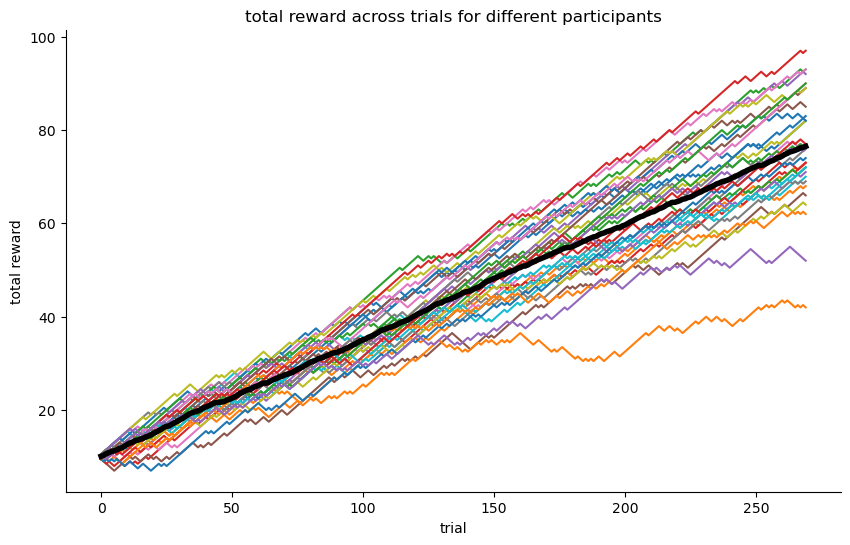

In [7]:
plt.figure(figsize=(10, 6))
participant_totalReward_list = []


for df in dataframes:
    participant_totalReward = df[df['totalReward'] != "na"]['totalReward'].tolist()
    participant_totalReward_list.append(participant_totalReward)
    plt.plot(participant_totalReward)
    
plt.xlabel("trial")
plt.ylabel("total reward")
plt.title("total reward across trials for different participants")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

mean_total_reward = np.mean(participant_totalReward_list, axis=0)
plt.plot(mean_total_reward, color='black', linewidth =  4, alpha = 1)
plt.savefig(os.path.join(output_folder, "total_reward_plot.pdf"), format="pdf", dpi=300, bbox_inches="tight")
plt.show()



<h2 style="color: green;">(1) Accuracy.</h2>

### (a) For each block. 

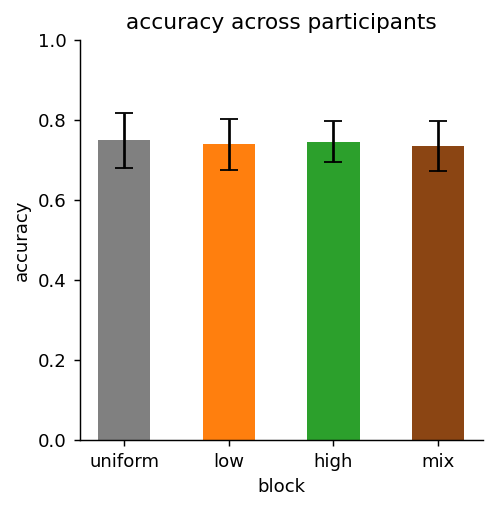

In [8]:
win_rates_all_participants = []

for df in dataframes:
    df['is_win'] = df['outcome'].apply(lambda x: 1 if x == 'win' else 0)
    total_trials = df.groupby('block_type').size().reset_index(name='total_trials')
    wins_per_block_type = df.groupby('block_type')['is_win'].sum().reset_index(name='wins')
    win_rate_df = pd.merge(total_trials, wins_per_block_type, on='block_type')
    win_rate_df['win_rate'] = win_rate_df['wins'] / win_rate_df['total_trials']
    
    win_rates_all_participants.append(win_rate_df[['block_type', 'win_rate']])

combined_win_rates = pd.concat(win_rates_all_participants)
mean_win_rates = combined_win_rates.groupby('block_type')['win_rate'].mean().reset_index()
std_win_rates = combined_win_rates.groupby('block_type')['win_rate'].std().reset_index()

mean_win_rates = mean_win_rates.merge(std_win_rates, on='block_type', suffixes=('_mean', '_std'))

mean_win_rates['block_type'] = pd.Categorical(
    mean_win_rates['block_type'], 
    categories=x_labels, 
    ordered=True
)

mean_win_rates = mean_win_rates.sort_values(by='block_type').reset_index(drop=True)

plot_with_error_bars(
    data=mean_win_rates,
    y_column_mean='win_rate_mean',
    y_column_std='win_rate_std',
    x_labels=x_labels,           
    title='accuracy across participants',
    y_label='accuracy',
    colors=colors,                
    annotation_offset=0.05,
    output_folder=output_folder,
    file_name="acc_acc_participants.pdf"
)


# ****************************************************************************

<h2 style="color: green;">(1_2) Accuracy, mix separated</h2>

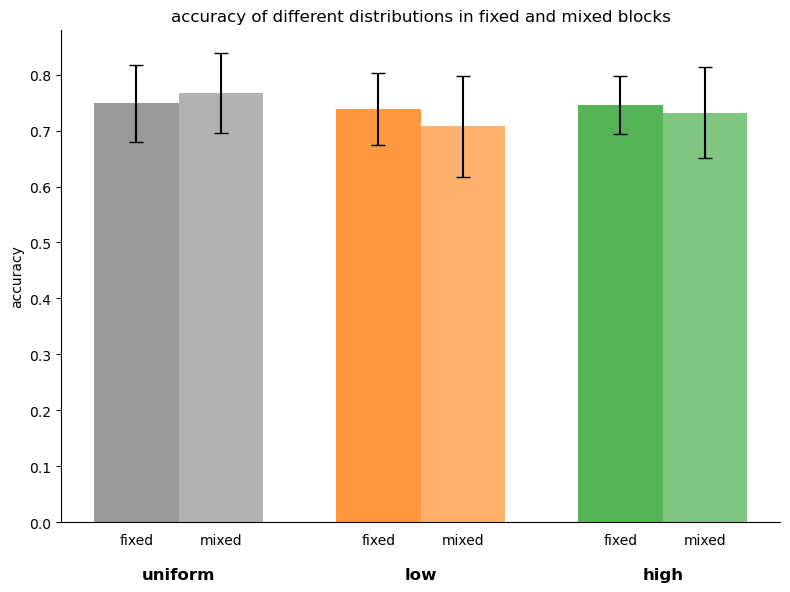

In [9]:
distributions_to_show = ['uniform', 'low', 'high']
colors = ['#808080', '#ff7f0e', '#2ca02c']

accuracy_mixed_all_participants = []

for df in dataframes:
    df_mixed = df[df['block_type'] == 'mix']
    accuracy_mixed = df_mixed.groupby('distribution')['is_win'].mean().reset_index()
    accuracy_mixed_all_participants.append(accuracy_mixed)

combined_accuracy_mixed = pd.concat(accuracy_mixed_all_participants)
mean_accuracy_mixed = combined_accuracy_mixed.groupby('distribution')['is_win'].mean().reset_index()
std_accuracy_mixed = combined_accuracy_mixed.groupby('distribution')['is_win'].std().reset_index()
mixed_win_rates = mean_accuracy_mixed.merge(std_accuracy_mixed, on='distribution', suffixes=('_mean', '_std'))

mixed_win_rates['distribution'] = pd.Categorical(
    mixed_win_rates['distribution'], 
    categories=distributions_to_show, 
    ordered=True
)
mixed_win_rates = mixed_win_rates.sort_values(by='distribution').reset_index(drop=True)

fixed_win_rates = mean_win_rates[mean_win_rates['block_type'].isin(distributions_to_show)]
fixed_win_rates = fixed_win_rates.set_index('block_type').reindex(distributions_to_show).reset_index()

bar_width = 0.35
x = np.arange(len(distributions_to_show))

fixed_means = fixed_win_rates['win_rate_mean']
fixed_stds = fixed_win_rates['win_rate_std']

mixed_means = mixed_win_rates['is_win_mean']
mixed_stds = mixed_win_rates['is_win_std']

fig, ax = plt.subplots(figsize=(8, 6))

bars_fixed = ax.bar(x - bar_width / 2, fixed_means, bar_width, 
                    yerr=fixed_stds, capsize=5, color=colors, alpha=0.8)

bars_mixed = ax.bar(x + bar_width / 2, mixed_means, bar_width, 
                    yerr=mixed_stds, capsize=5, color=colors, alpha=0.6)

ax.set_xticks([])
for i, dist in enumerate(distributions_to_show):
    fixed_x = x[i] - bar_width / 2
    mixed_x = x[i] + bar_width / 2
    
    ax.text(fixed_x, -0.02, 'fixed', ha='center', va='top', fontsize=10, transform=ax.transData)
    ax.text(mixed_x, -0.02, 'mixed', ha='center', va='top', fontsize=10, transform=ax.transData)
    
    ax.text(x[i], -0.08, dist, ha='center', va='top', fontsize=12, fontweight='bold', transform=ax.transData)

ax.set_ylabel('accuracy')

title_text = 'accuracy of different distributions in fixed and mixed blocks'
ax.set_title(title_text)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "different_distribution_accuracy_fix_mix.pdf"), format="pdf", dpi=300, bbox_inches="tight")
plt.show()
# tod

<h2 style="color: green;">(2) Fixed Block: Response Time.</h2>

### (a) Average for each block for card reveal 

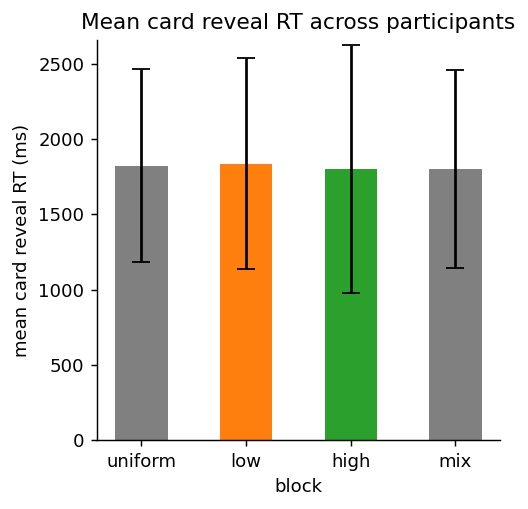

In [10]:
spaceRT_all_participants = []

for df in dataframes:
    spaceRT_2sd_threshold = df['spaceRT_2sd'].iloc[0]
    
    df_filtered = df[df['spaceRT'] <= spaceRT_2sd_threshold]
    
    mean_spaceRT_df = df_filtered.groupby('block_type')['spaceRT'].mean().reset_index()
    mean_spaceRT_df.rename(columns={'spaceRT': 'mean_spaceRT'}, inplace=True)
    
    spaceRT_all_participants.append(mean_spaceRT_df[['block_type', 'mean_spaceRT']])

combined_spaceRT = pd.concat(spaceRT_all_participants)
mean_spaceRT = combined_spaceRT.groupby('block_type')['mean_spaceRT'].mean().reset_index()
std_spaceRT = combined_spaceRT.groupby('block_type')['mean_spaceRT'].std().reset_index()

mean_spaceRT = mean_spaceRT.merge(std_spaceRT, on='block_type', suffixes=('_mean', '_std'))

mean_spaceRT['block_type'] = pd.Categorical(
    mean_spaceRT['block_type'], 
    categories=x_labels, 
    ordered=True
)

mean_spaceRT = mean_spaceRT.sort_values(by='block_type').reset_index(drop=True)

plot_with_error_bars(
    data=mean_spaceRT,
    y_column_mean='mean_spaceRT_mean',
    y_column_std='mean_spaceRT_std',
    x_labels=x_labels,
    title='Mean card reveal RT across participants',
    y_label='mean card reveal RT (ms)',
    colors=colors,
    annotation_offset=100,
    output_folder=output_folder,
    file_name="mean_reveal_RT.pdf"
)


### (b) Average for each block for card response 

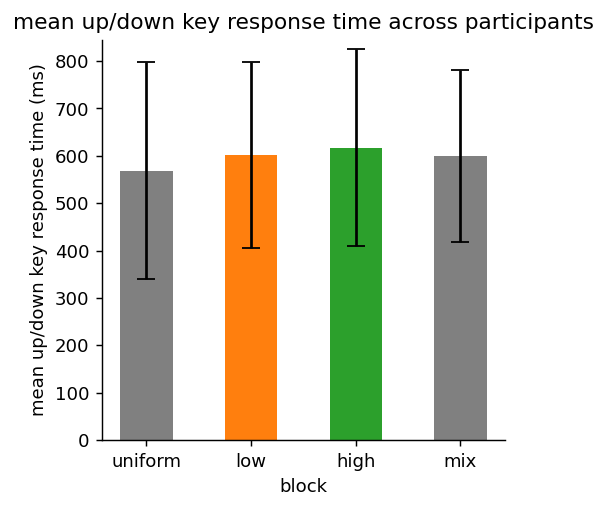

In [11]:
arrowRT_all_participants = []

for df in dataframes:
    df_filtered = df[df['arrowRT'] != 'na'].copy()
    df_filtered['arrowRT'] = pd.to_numeric(df_filtered['arrowRT'], errors='coerce')

    mean_arrowRT_df = df_filtered.groupby('block_type')['arrowRT'].mean().reset_index()
    mean_arrowRT_df.rename(columns={'arrowRT': 'mean_arrowRT'}, inplace=True)
    
    arrowRT_all_participants.append(mean_arrowRT_df[['block_type', 'mean_arrowRT']])

combined_arrowRT = pd.concat(arrowRT_all_participants)
mean_arrowRT = combined_arrowRT.groupby('block_type')['mean_arrowRT'].mean().reset_index()
std_arrowRT = combined_arrowRT.groupby('block_type')['mean_arrowRT'].std().reset_index()

mean_arrowRT = mean_arrowRT.merge(std_arrowRT, on='block_type', suffixes=('_mean', '_std'))

mean_arrowRT['block_type'] = pd.Categorical(
    mean_arrowRT['block_type'], 
    categories=x_labels, 
    ordered=True
)

mean_arrowRT = mean_arrowRT.sort_values(by='block_type').reset_index(drop=True)

plot_with_error_bars(
    data=mean_arrowRT,
    y_column_mean='mean_arrowRT_mean',
    y_column_std='mean_arrowRT_std',
    x_labels=x_labels,
    title='mean up/down key response time across participants',
    y_label='mean up/down key response time (ms)',
    colors=colors,
    annotation_offset=100,
    output_folder=output_folder,
    file_name="mean_up_down_key.pdf"
)


# ****************************************************************************

<h2 style="color: green;">(2_1) Average response time for arrowRT </h2>

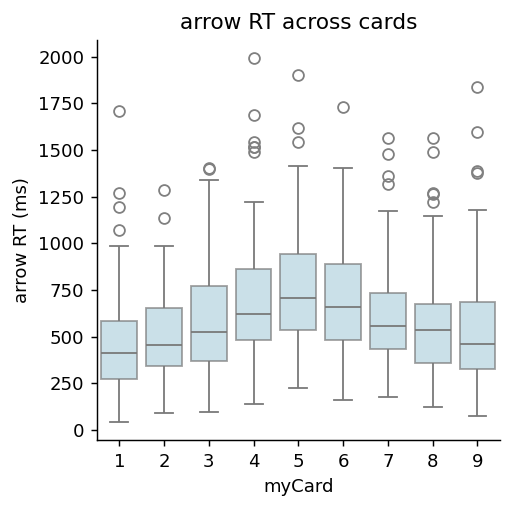

In [12]:
arrowRT_by_card_block_all_participants = []

for df in dataframes:
    df['arrowRT'] = pd.to_numeric(df['arrowRT'], errors='coerce')
    
    arrow_rt_means = df.groupby(['myCard', 'block_type'])['arrowRT'].mean().reset_index()
    
    arrowRT_by_card_block_all_participants.append(arrow_rt_means)

combined_arrowRT = pd.concat(arrowRT_by_card_block_all_participants)

combined_arrowRT['myCard'] = combined_arrowRT['myCard'].astype(int)

mean_std_arrowRT_across_participants = combined_arrowRT.groupby('myCard')['arrowRT'].agg(['mean', 'std']).reset_index()

plt.figure(dpi=130, figsize=(4, 4))

sns.boxplot(
    data=combined_arrowRT,
    x='myCard',
    y='arrowRT',
    color='lightblue',
    boxprops=dict(alpha=0.7),
    flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='gray', markersize=6)  # Custom outliers
)

plt.xlabel('myCard')
plt.ylabel('arrow RT (ms)')
plt.title('arrow RT across cards')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(os.path.join(output_folder, "arrow_up_down_RT.pdf"), format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# todo: 1-way ANOVA. 1 factor with 9 levels.
# todo: post-hoc test. HST, similar to Bonferroni correction, less conservative as BC.

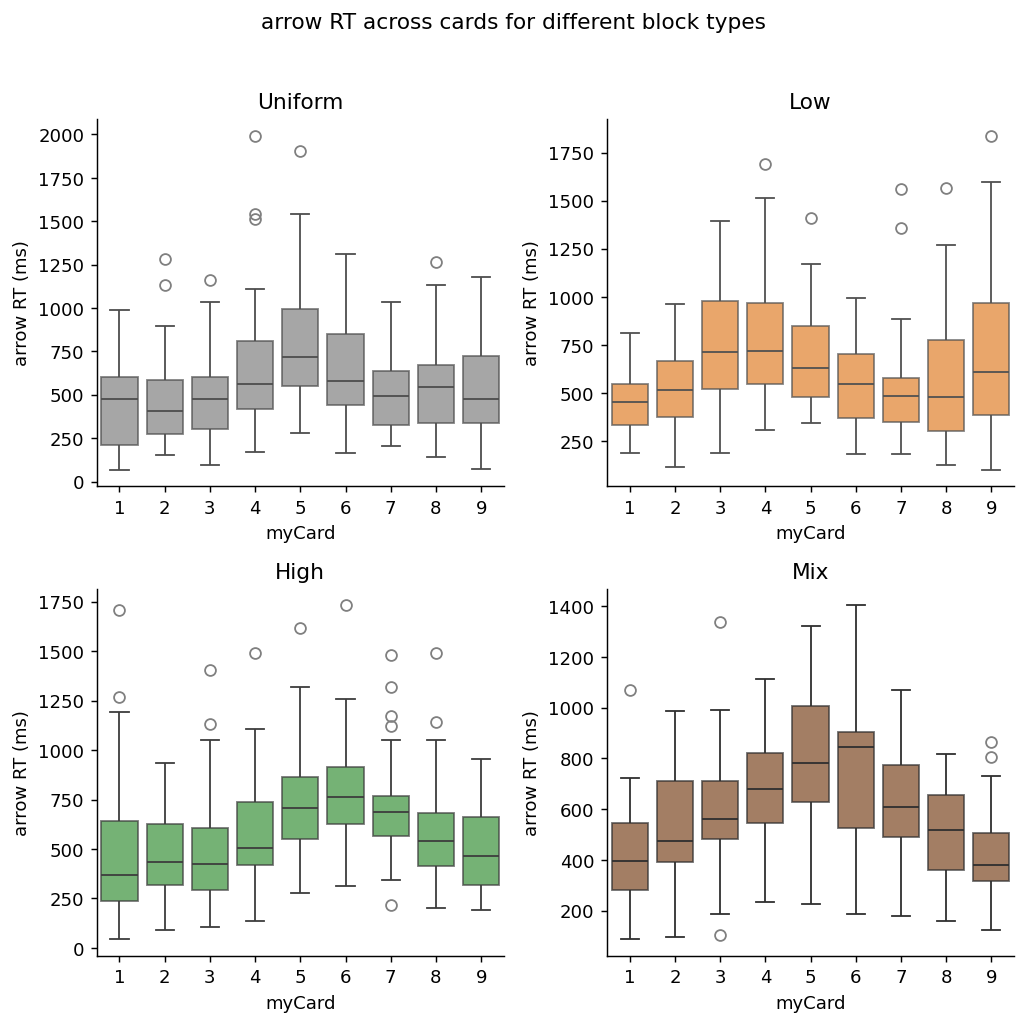

In [13]:
from matplotlib.ticker import MaxNLocator

arrowRT_by_card_block_all_participants = []

for df in dataframes:
    df['arrowRT'] = pd.to_numeric(df['arrowRT'], errors='coerce')
    df['myCard'] = df['myCard'].astype(int)  # Ensure 'myCard' is treated as an integer
    
    arrow_rt_means = df.groupby(['myCard', 'block_type'])['arrowRT'].mean().reset_index()
    arrowRT_by_card_block_all_participants.append(arrow_rt_means)

# Concatenate all dataframes
combined_arrowRT = pd.concat(arrowRT_by_card_block_all_participants)

# Define the x_labels (block types) and their colors
x_labels = ['uniform', 'low', 'high', 'mix']
colors = ['#808080',  '#ff7f0e', '#2ca02c', '#8B4513']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=130)
fig.suptitle('arrow RT across cards for different block types')

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop over each block type in x_labels
for i, block in enumerate(x_labels):
    # Filter data for the current block type
    block_data = combined_arrowRT[combined_arrowRT['block_type'] == block]
    
    # Plot boxplot on the respective subplot
    sns.boxplot(
        data=block_data,
        x='myCard',
        y='arrowRT',
        color=colors[i],  # Use the corresponding color for each block type
        ax=axes[i],
        boxprops=dict(alpha=0.7),
        flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='gray', markersize=6)  # Custom outliers

    )
    
    # Set labels and title for each subplot
    axes[i].set_title(f'{block.capitalize()}')
    axes[i].set_xlabel('myCard')
    axes[i].set_ylabel('arrow RT (ms)')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    # Ensure x-axis displays integer labels
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for the main title
plt.savefig(os.path.join(output_folder, "arrow_up_down_for_cards.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()


#Todo: take a look at RTs throughout the time.
#Todo: break the mix panel down in to different ditributions. 


<h2 style="color: green;">(2_2) acc for different numbers in different block</h2>

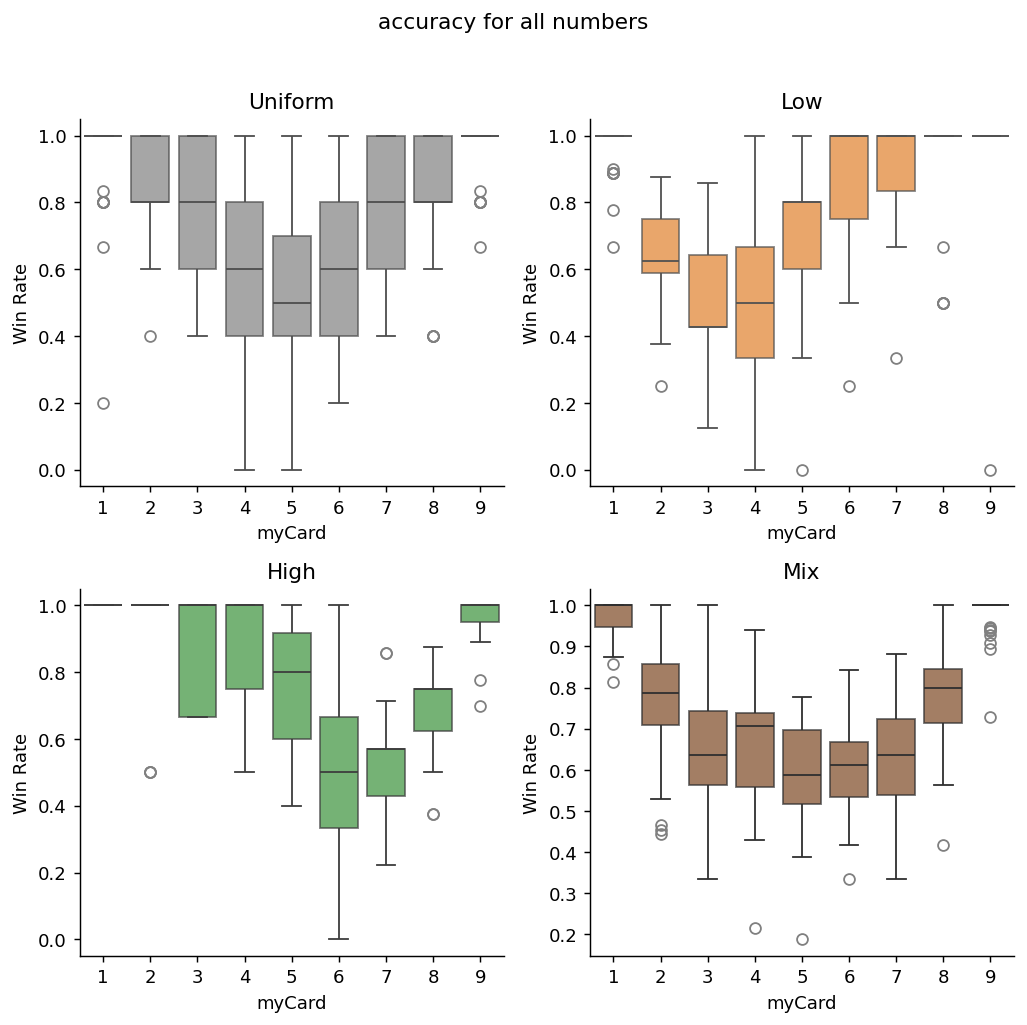

In [14]:
# Initialize list to hold accuracy data for each dataframe
accuracy_by_card_block_all_participants = []

for df in dataframes:
    # Ensure 'outcome' is a string
    df['outcome'] = df['outcome'].astype(str)
    
    # Calculate accuracy by checking if outcome is "win"
    df['is_win'] = df['outcome'] == 'win'
    
    # Group by myCard and block_type, then calculate accuracy rate (win rate)
    accuracy_rate = df.groupby(['myCard', 'block_type'])['is_win'].mean().reset_index()
    accuracy_rate.rename(columns={'is_win': 'accuracy_rate'}, inplace=True)  # Rename column for clarity
    
    accuracy_by_card_block_all_participants.append(accuracy_rate)

# Concatenate all accuracy dataframes into one
combined_accuracy = pd.concat(accuracy_by_card_block_all_participants)

# Plotting the accuracy data in a similar way as the arrowRT data
fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=130)
fig.suptitle('accuracy for all numbers')

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop over each block type in x_labels
for i, block in enumerate(x_labels):
    # Filter data for the current block type
    block_data = combined_accuracy[combined_accuracy['block_type'] == block]
    
    # Plot boxplot on the respective subplot
    sns.boxplot(
        data=block_data,
        x='myCard',
        y='accuracy_rate',
        color=colors[i],  # Use the corresponding color for each block type
        ax=axes[i],
        boxprops=dict(alpha=0.7),
        flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='gray', markersize=6)  # Custom outliers
    )
    
    # Set labels and title for each subplot
    axes[i].set_title(f'{block.capitalize()}')
    axes[i].set_xlabel('myCard')
    axes[i].set_ylabel('Win Rate')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    # Ensure x-axis displays integer labels
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for the main title
plt.savefig(os.path.join(output_folder, "acc_for_cards.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()


<h2 style="color: green;">(3) Arrow Press</h2>

## (a-1) Up down press for 1-4, 5, and 6-9 in uniform distribution in fixed block

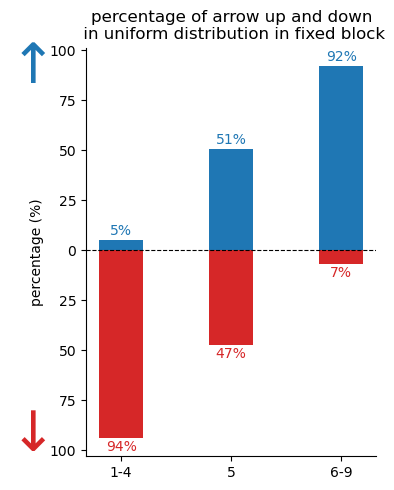

In [15]:
group_results = []

for df in dataframes:
    uniform_df = df[df['block_type'] == 'uniform'].copy()
    uniform_df.loc[:, 'group'] = pd.cut(
        uniform_df['myCard'],
        bins=[0, 4, 5, 9], 
        labels=['1-4', '5', '6-9']
    )
    group_counts = uniform_df.groupby(['group', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['group'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()

groups = combined_results['group']
arrow_up = combined_results.get('arrowup', 0)
arrow_down = combined_results.get('arrowdown', 0)

x = np.arange(len(groups))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(4, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color='#1f77b4')
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color='#d62728')

ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

ax.set_ylabel('percentage (%)')
ax.set_title('percentage of arrow up and down\n in uniform distribution in fixed block')

ax.text(-0.8, ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-0.8, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_uniform_fix_5.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()


## (a-1) Up down press for 1-9 in uniform distribution in fixed block

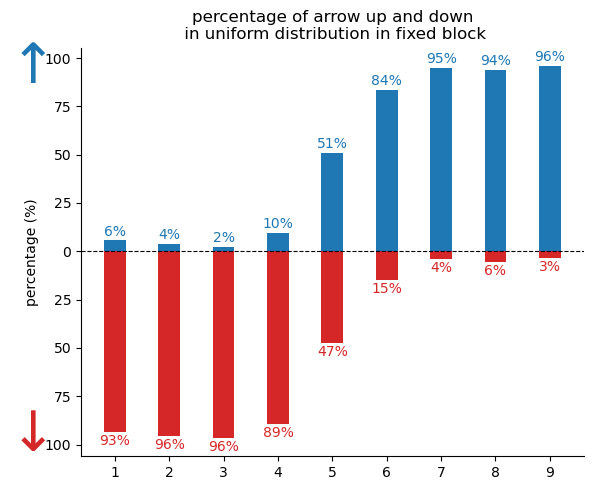

In [16]:
group_results = []

for df in dataframes:
    # Filter for uniform blocks
    uniform_df = df[df['block_type'] == 'uniform'].copy()
    
    # Assign each number 1 to 9 directly as groups
    uniform_df['group'] = uniform_df['myCard'].astype(str)  # Convert myCard to string for grouping and labeling
    
    # Calculate counts and percentages
    group_counts = uniform_df.groupby(['group', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['group'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

# Combine results across all DataFrames and compute mean
combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()

# Extract data for plotting
groups = combined_results['group']
arrow_up = combined_results.get('arrowup', 0)
arrow_down = combined_results.get('arrowdown', 0)

x = np.arange(len(groups))
bar_width = 0.4

# Plotting
fig, ax = plt.subplots(figsize=(6, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

# Add percentage labels above bars
for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color='#1f77b4')
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color='#d62728')

ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

ax.set_ylabel('percentage (%)')
ax.set_title('percentage of arrow up and down\n in uniform distribution in fixed block')

ax.text(-1.5 ,ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-1.5, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_uniform_fix.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()


## (a-1) Up down press for 1-9 in low distribution in fixed block

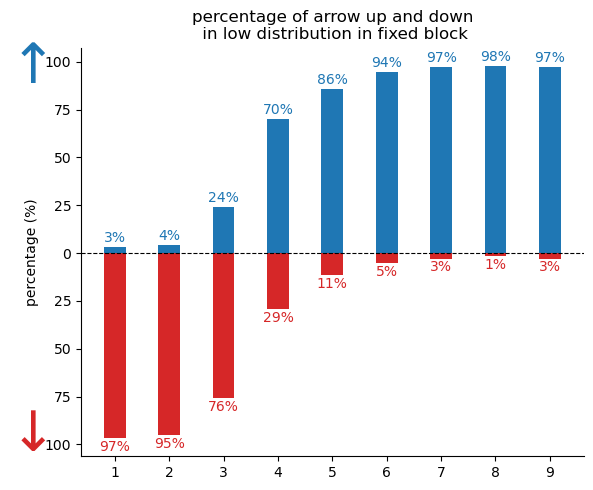

In [17]:
group_results = []

for df in dataframes:
    # Filter for low blocks
    low_df = df[df['block_type'] == 'low'].copy()
    
    # Assign each number 1 to 9 directly as groups
    low_df['group'] = low_df['myCard'].astype(str)  # Convert myCard to string for grouping and labeling
    
    # Calculate counts and percentages
    group_counts = low_df.groupby(['group', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['group'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

# Combine results across all DataFrames and compute mean
combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()

# Extract data for plotting
groups = combined_results['group']
arrow_up = combined_results.get('arrowup', 0)
arrow_down = combined_results.get('arrowdown', 0)

x = np.arange(len(groups))
bar_width = 0.4

# Plotting
fig, ax = plt.subplots(figsize=(6, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

# Add percentage labels above bars
for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color='#1f77b4')
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color='#d62728')

ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

ax.set_ylabel('percentage (%)')
ax.set_title('percentage of arrow up and down\n in low distribution in fixed block')

ax.text(-1.5 ,ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-1.5, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_low_fix.pdf"), format="pdf", dpi=300, bbox_inches="tight")


plt.show()


## (a-1) Up down press for 1-9 in high distribution in fixed block

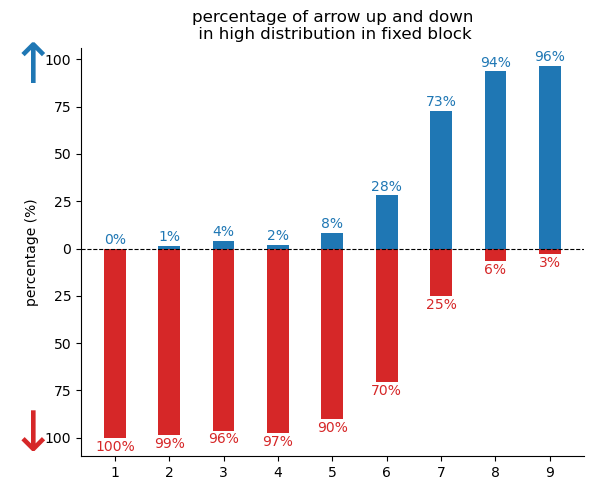

In [18]:
group_results = []

for df in dataframes:
    # Filter for high blocks
    high_df = df[df['block_type'] == 'high'].copy()
    
    # Assign each number 1 to 9 directly as groups
    high_df['group'] = high_df['myCard'].astype(str)  # Convert myCard to string for grouping and labeling
    
    # Calculate counts and percentages
    group_counts = high_df.groupby(['group', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['group'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

# Combine results across all DataFrames and compute mean
combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()

# Extract data for plotting
groups = combined_results['group']
arrow_up = combined_results.get('arrowup', 0)
arrow_down = combined_results.get('arrowdown', 0)

x = np.arange(len(groups))
bar_width = 0.4

# Plotting
fig, ax = plt.subplots(figsize=(6, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

# Add percentage labels above bars
for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color='#1f77b4')
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color='#d62728')

ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

ax.set_ylabel('percentage (%)')
ax.set_title('percentage of arrow up and down\n in high distribution in fixed block')

ax.text(-1.5 ,ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-1.5, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_high_fix.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()


## (a-2) Up down press for 1-4, 5, and 6-9 in uniform distribution in mixed block

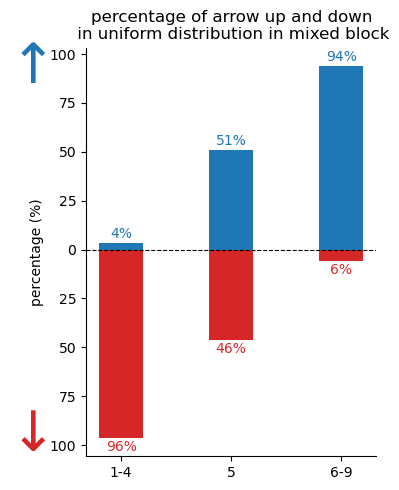

In [19]:
group_results = []

for df in dataframes:
    mix_df = df[(df['block_type'] == 'mix') & (df['distribution'] == 'uniform')].copy()
    mix_df.loc[:, 'group'] = pd.cut(
        mix_df['myCard'],
        bins=[0, 4, 5, 9], 
        labels=['1-4', '5', '6-9']
    )
    group_counts = mix_df.groupby(['group', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['group'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()

groups = combined_results['group']
arrow_up = combined_results.get('arrowup', 0)
arrow_down = combined_results.get('arrowdown', 0)

x = np.arange(len(groups))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(4, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color='#1f77b4')
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color='#d62728')

ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

ax.set_ylabel('percentage (%)')
ax.set_title('percentage of arrow up and down\n in uniform distribution in mixed block')

ax.text(-0.8, ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-0.8, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_uniform_mix_5.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()


## (a-2) Up down press for 1-9 in uniform distribution in mixed block

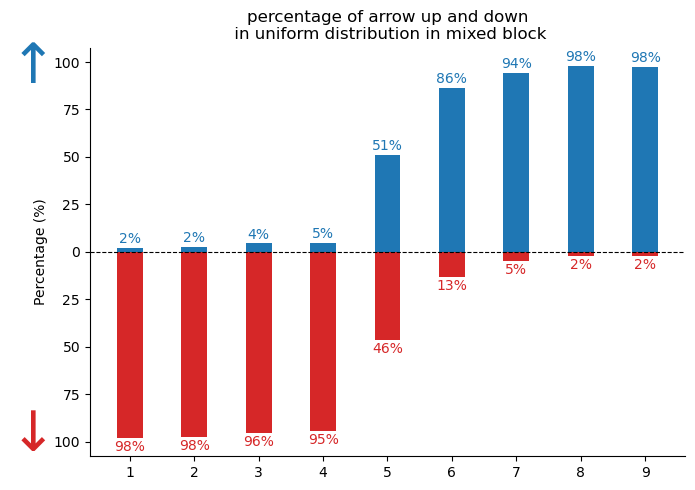

In [20]:
group_results = []

for df in dataframes:
    # Filter for mixed blocks with uniform distribution
    mix_df = df[(df['block_type'] == 'mix') & (df['distribution'] == 'uniform')].copy()
    
    # Bin `myCard` values into individual groups from 1 to 9
    mix_df.loc[:, 'group'] = pd.cut(
        mix_df['myCard'],
        bins=np.arange(0.5, 10.5, 1),  # Create bins for 1, 2, ..., 9
        labels=list(range(1, 10))  # Label each bin with corresponding number
    )
    
    # Count occurrences of each choice per group
    group_counts = mix_df.groupby(['group', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['group'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

# Combine results across dataframes and calculate means
combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()

# Prepare data for plotting
groups = combined_results['group']
arrow_up = combined_results.get('arrowup', 0)
arrow_down = combined_results.get('arrowdown', 0)

x = np.arange(len(groups))
bar_width = 0.4

# Create the bar plot
fig, ax = plt.subplots(figsize=(7, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

# Annotate the bars
for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color='#1f77b4')
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color='#d62728')

# Set x-axis labels and style
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Format y-axis tick labels to remove negative sign
yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

# Labels and title
ax.set_ylabel('Percentage (%)')
ax.set_title('percentage of arrow up and down\n in uniform distribution in mixed block')

# Add upward and downward arrows
ax.text(-1.5, ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-1.5, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

# Remove unnecessary spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_uniform_mix.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()


## (a-2) Up down press for 1-9 in low distribution in mixed block

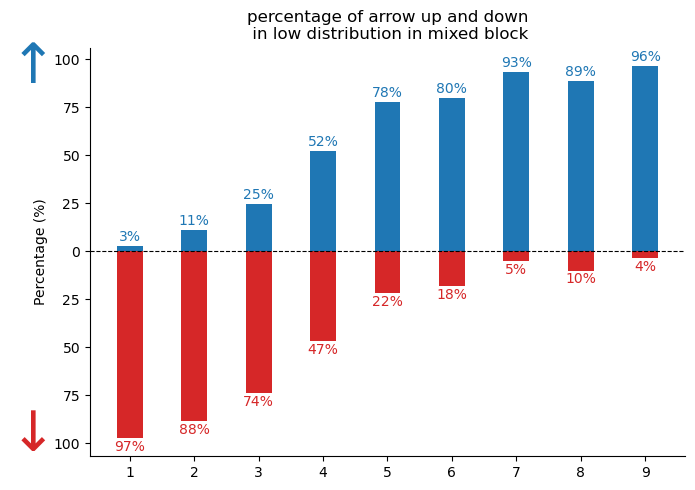

In [21]:
group_results = []

for df in dataframes:
    # Filter for mixed blocks with low distribution
    mix_df = df[(df['block_type'] == 'mix') & (df['distribution'] == 'low')].copy()
    
    # Bin `myCard` values into individual groups from 1 to 9
    mix_df.loc[:, 'group'] = pd.cut(
        mix_df['myCard'],
        bins=np.arange(0.5, 10.5, 1),  # Create bins for 1, 2, ..., 9
        labels=list(range(1, 10))  # Label each bin with corresponding number
    )
    
    # Count occurrences of each choice per group
    group_counts = mix_df.groupby(['group', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['group'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

# Combine results across dataframes and calculate means
combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()

# Prepare data for plotting
groups = combined_results['group']
arrow_up = combined_results.get('arrowup', 0)
arrow_down = combined_results.get('arrowdown', 0)

x = np.arange(len(groups))
bar_width = 0.4

# Create the bar plot
fig, ax = plt.subplots(figsize=(7, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

# Annotate the bars
for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color='#1f77b4')
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color='#d62728')

# Set x-axis labels and style
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Format y-axis tick labels to remove negative sign
yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

# Labels and title
ax.set_ylabel('Percentage (%)')
ax.set_title('percentage of arrow up and down\n in low distribution in mixed block')

# Add upward and downward arrows
ax.text(-1.5, ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-1.5, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

# Remove unnecessary spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_low_mix.pdf"), format="pdf", dpi=300, bbox_inches="tight")


plt.show()


## (a-2) Up down press for 1-9 in high distribution in mixed block

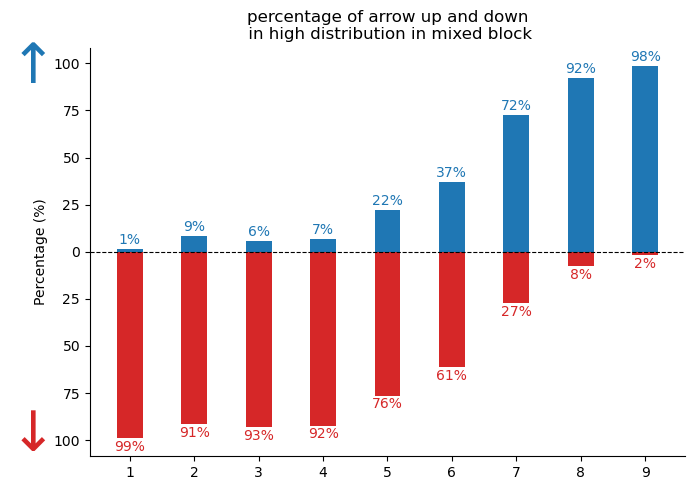

In [22]:
group_results = []

for df in dataframes:
    # Filter for mixed blocks with high distribution
    mix_df = df[(df['block_type'] == 'mix') & (df['distribution'] == 'high')].copy()
    
    # Bin `myCard` values into individual groups from 1 to 9
    mix_df.loc[:, 'group'] = pd.cut(
        mix_df['myCard'],
        bins=np.arange(0.5, 10.5, 1),  # Create bins for 1, 2, ..., 9
        labels=list(range(1, 10))  # Label each bin with corresponding number
    )
    
    # Count occurrences of each choice per group
    group_counts = mix_df.groupby(['group', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['group'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

# Combine results across dataframes and calculate means
combined_results = pd.concat(group_results).groupby('group', observed=True).mean().reset_index()

# Prepare data for plotting
groups = combined_results['group']
arrow_up = combined_results.get('arrowup', 0)
arrow_down = combined_results.get('arrowdown', 0)

x = np.arange(len(groups))
bar_width = 0.4

# Create the bar plot
fig, ax = plt.subplots(figsize=(7, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color='#1f77b4')
bars_down = ax.bar(x, -arrow_down, bar_width, color='#d62728')

# Annotate the bars
for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color='#1f77b4')
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color='#d62728')

# Set x-axis labels and style
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Format y-axis tick labels to remove negative sign
yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

# Labels and title
ax.set_ylabel('Percentage (%)')
ax.set_title('percentage of arrow up and down\n in high distribution in mixed block')

# Add upward and downward arrows
ax.text(-1.5, ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-1.5, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

# Remove unnecessary spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_high_mix.pdf"), format="pdf", dpi=300, bbox_inches="tight")


plt.show()


## (b) Up down press for fixed blocks

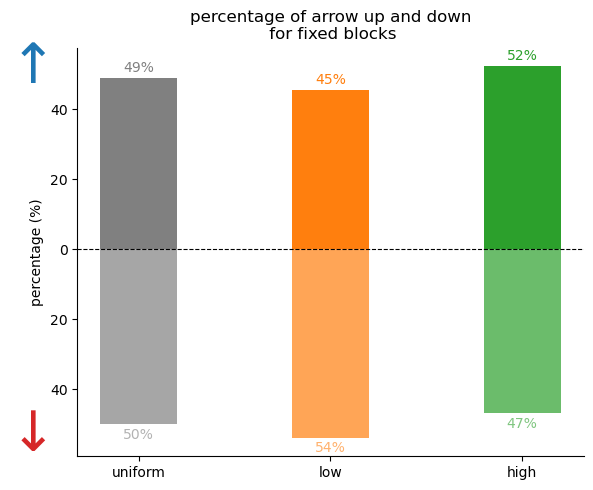

In [23]:
distributions_to_show = ['uniform', 'low', 'high']
colors = ['#808080', '#ff7f0e', '#2ca02c']

group_results = []

for df in dataframes:
    block_types_df = df[df['block_type'].isin(distributions_to_show)].copy()
    group_counts = block_types_df.groupby(['block_type', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['block_type'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

combined_results = pd.concat(group_results).groupby('block_type', observed=True).mean().reset_index()

combined_results['block_type'] = pd.Categorical(combined_results['block_type'], categories=distributions_to_show, ordered=True)
combined_results = combined_results.sort_values('block_type')

groups = combined_results['block_type']
arrow_up = combined_results.set_index('block_type').reindex(distributions_to_show)['arrowup'].values
arrow_down = combined_results.set_index('block_type').reindex(distributions_to_show)['arrowdown'].values

x = np.arange(len(distributions_to_show))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(6, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color=colors, label='Arrow Up')
bars_down = ax.bar(x, -arrow_down, bar_width, color=colors, alpha=0.7, label='Arrow Down')

for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color=colors[i])
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color=colors[i], alpha=0.6)

ax.set_xticks(x)
ax.set_xticklabels(distributions_to_show)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

ax.set_ylabel('percentage (%)')
ax.set_title('percentage of arrow up and down\n for fixed blocks')

ax.text(-0.55, ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-0.55, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_fix.pdf"), format="pdf", dpi=300, bbox_inches="tight")
plt.show()


## (c) Up down press for each distribution in mixed blocks

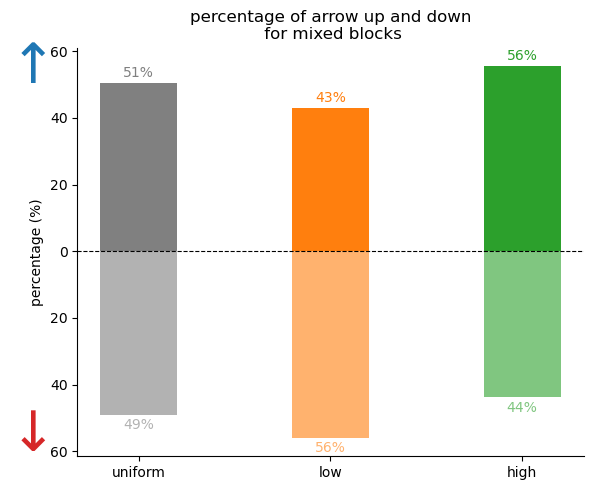

In [24]:
distributions_to_show = ['uniform', 'low', 'high']
colors = ['#808080', '#ff7f0e', '#2ca02c']

group_results = []

for df in dataframes:
    mix_df = df[(df['block_type'] == 'mix') & (df['distribution'].isin(distributions_to_show))].copy()
    group_counts = mix_df.groupby(['distribution', 'choice'], observed=True)['choice'].count().unstack(fill_value=0)
    group_totals = group_counts.sum(axis=1)
    group_percentages = (group_counts.T / group_totals).T * 100
    group_percentages['distribution'] = group_percentages.index
    group_results.append(group_percentages.reset_index(drop=True))

combined_results = pd.concat(group_results).groupby('distribution', observed=True).mean().reset_index()

combined_results['distribution'] = pd.Categorical(combined_results['distribution'], categories=distributions_to_show, ordered=True)
combined_results = combined_results.sort_values('distribution')

groups = combined_results['distribution']
arrow_up = combined_results.set_index('distribution').reindex(distributions_to_show)['arrowup'].values
arrow_down = combined_results.set_index('distribution').reindex(distributions_to_show)['arrowdown'].values

x = np.arange(len(distributions_to_show))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(6, 5))

bars_up = ax.bar(x, arrow_up, bar_width, color=colors, label='Arrow Up')
bars_down = ax.bar(x, -arrow_down, bar_width, color=colors, alpha=0.6, label='Arrow Down')

for i in range(len(x)):
    ax.text(x[i], arrow_up[i] + 1, f'{round(arrow_up[i])}%', ha='center', va='bottom', fontsize=10, color=colors[i])
    ax.text(x[i], -arrow_down[i] - 1, f'{round(arrow_down[i])}%', ha='center', va='top', fontsize=10, color=colors[i], alpha=0.6)

ax.set_xticks(x)
ax.set_xticklabels(distributions_to_show)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

yticks = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.set_yticklabels([abs(int(tick)) if tick < 0 else int(tick) for tick in yticks])

ax.set_ylabel('percentage (%)')
ax.set_title('percentage of arrow up and down\n for mixed blocks')

ax.text(-0.55, ax.get_ylim()[1] * 0.9, '↑', color='#1f77b4', fontsize=40, ha='center', va='center')
ax.text(-0.55, ax.get_ylim()[0] * 0.9, '↓', color='#d62728', fontsize=40, ha='center', va='center')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
plt.savefig(os.path.join(output_folder, "arrow_up_down_percent_mix.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()


# ****************************************************************************

<h2 style="color: green;">(4) spaceRT and arrowRT in mix  blocks </h2>
In the mixed block, are the reaction times generally slower than the fixed blocks, because of task switching? Calculate average RT for every trial that follows the same color (green, uniform, uniform, orange, orange) as a “congruent” non-switch trial, and RT for every trial that is different from the color before (green, uniform, uniform, orange, orange) as an “incongruent” switch trial cost.

In [25]:
mean_RT_same_results = []
mean_RT_different_results = []

for df in dataframes:
    # Ensure "arrowRT" is numeric and "spaceRT_2sd" is consistent across rows
    df['arrowRT'] = pd.to_numeric(df['arrowRT'], errors='coerce')
    
    if 'spaceRT_2sd' not in df or df['spaceRT_2sd'].isnull().all():
        continue  # Skip if "spaceRT_2sd" is missing or all values are NaN
    
    spaceRT_2sd_threshold = df['spaceRT_2sd'].iloc[0]
    
    # Filter to include only rows where spaceRT is within the threshold and block_type is 'mix'
    df_mix = df[(df['block_type'] == 'mix') & (df['spaceRT'] <= spaceRT_2sd_threshold)].copy()
    
    if df_mix.empty:
        continue  # Skip if filtered DataFrame is empty
    
    # Identify whether the current row's distribution matches the previous row's
    df_mix['same_as_previous'] = df_mix['distribution'] == df_mix['distribution'].shift(1)
    
    # Rows where distribution is the same as the previous row
    df_same_dist = df_mix[df_mix['same_as_previous']].copy()
    if not df_same_dist.empty:
        mean_RT_same = df_same_dist.groupby('distribution').agg({
            'spaceRT': 'mean',
            'arrowRT': 'mean',
            'is_win': 'mean'  # Calculate accuracy as mean of 'is_win'
        }).reset_index()
        mean_RT_same_results.append(mean_RT_same)
    
    # Rows where distribution is different from the previous row
    df_mix['different_from_previous'] = ~df_mix['same_as_previous']
    df_different_dist = df_mix[df_mix['different_from_previous']].copy()
    if not df_different_dist.empty:
        mean_RT_different = df_different_dist.groupby('distribution').agg({
            'spaceRT': 'mean',
            'arrowRT': 'mean',
            'is_win': 'mean'  # Calculate accuracy as mean of 'is_win'
        }).reset_index()
        mean_RT_different_results.append(mean_RT_different)

# Combine results across all dataframes
combined_mean_RT_same = pd.concat(mean_RT_same_results, ignore_index=True) if mean_RT_same_results else pd.DataFrame()
combined_mean_RT_different = pd.concat(mean_RT_different_results, ignore_index=True) if mean_RT_different_results else pd.DataFrame()

# Calculate mean and standard deviation across all subjects for "same" condition
if not combined_mean_RT_same.empty:
    mean_std_across_same = combined_mean_RT_same.groupby('distribution')[['spaceRT', 'arrowRT', 'is_win']].agg(['mean', 'std']).reset_index()
    mean_std_across_same.columns = ['distribution', 'spaceRT_mean', 'spaceRT_std', 'arrowRT_mean', 'arrowRT_std', 'accuracy_mean', 'accuracy_std']
else:
    mean_std_across_same = pd.DataFrame()

# Calculate mean and standard deviation across all subjects for "different" condition
if not combined_mean_RT_different.empty:
    mean_std_across_different = combined_mean_RT_different.groupby('distribution')[['spaceRT', 'arrowRT', 'is_win']].agg(['mean', 'std']).reset_index()
    mean_std_across_different.columns = ['distribution', 'spaceRT_mean', 'spaceRT_std', 'arrowRT_mean', 'arrowRT_std', 'accuracy_mean', 'accuracy_std']
else:
    mean_std_across_different = pd.DataFrame()


## congruent/stay vs incongruent/ switch

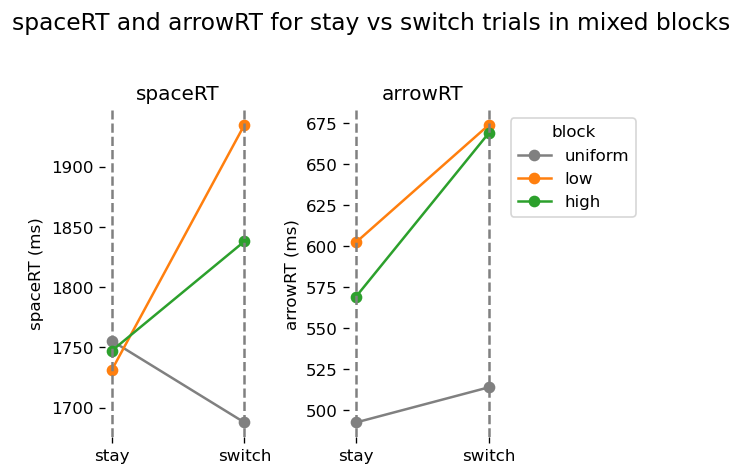

In [26]:
distributions_to_show = ['uniform', 'low', 'high']
colors = ['#808080', '#ff7f0e', '#2ca02c']


mixed_spaceRT_different = mean_std_across_different.set_index('distribution').reindex(distributions_to_show)['spaceRT_mean'].values
mixed_arrowRT_different = mean_std_across_different.set_index('distribution').reindex(distributions_to_show)['arrowRT_mean'].values


mixed_spaceRT_same = mean_std_across_same.set_index('distribution').reindex(distributions_to_show)['spaceRT_mean'].values
mixed_arrowRT_same = mean_std_across_same.set_index('distribution').reindex(distributions_to_show)['arrowRT_mean'].values

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), dpi=120)

# Add a title to the entire figure with "congruent/stay" in bold
fig.suptitle(r'spaceRT and arrowRT for stay vs switch trials in mixed blocks', fontsize=14)

# Left subplot for SpaceRT
for i, dist in enumerate(distributions_to_show):
    ax1.plot(['Fixed', 'Mixed'], [ mixed_spaceRT_same[i], mixed_spaceRT_different[i]], marker='o', label=dist, color=colors[i])

# Add vertical dashed lines
ax1.axvline(x=0, color='gray', linestyle='--')
ax1.axvline(x=1, color='gray', linestyle='--')

# Set labels and title for SpaceRT subplot
ax1.set_title('spaceRT')
ax1.set_ylabel('spaceRT (ms)')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['stay', 'switch'])

# Hide spines for a clean look
for spine in ['left', 'bottom', 'top', 'right']:
    ax1.spines[spine].set_visible(False)

# Right subplot for ArrowRT
for i, dist in enumerate(distributions_to_show):
    ax2.plot(['Fixed', 'Mixed'], [ mixed_arrowRT_same[i], mixed_arrowRT_different[i]], marker='o', label=dist, color=colors[i])

# Add vertical dashed lines
ax2.axvline(x=0, color='gray', linestyle='--')
ax2.axvline(x=1, color='gray', linestyle='--')

# Set labels and title for ArrowRT subplot
ax2.set_title('arrowRT')
ax2.set_ylabel('arrowRT (ms)')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['stay', 'switch'])
ax2.legend(title='block', bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide spines for a clean look
for spine in ['left', 'bottom', 'top', 'right']:
    ax2.spines[spine].set_visible(False)

# Adjust layout to fit title and legend outside the subplots
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust to make space for title and legend
plt.savefig(os.path.join(output_folder, "stay_switch_space_arrow_RT.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()
 

<h2 style="color: green;">(5) Mixed Block: Stay/Switch Accuracy. </h2>
 Calculate accuracy on every trial in the mixed block that was the same color as the trial before (stay accuracy). Calculate accuracy on every trial in the mixed block that was not the same color as the trial before (switch accuracy). 

 

## a) stay accuracy vs switch accuracy

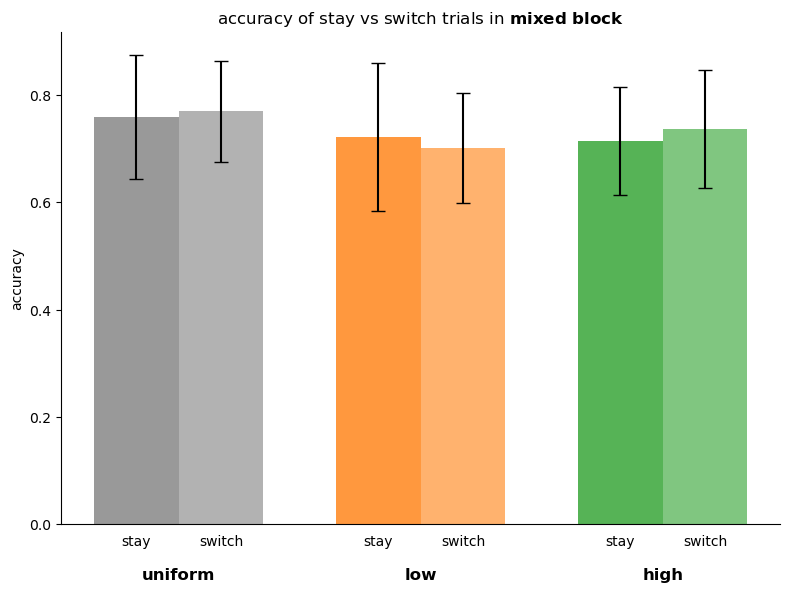

In [27]:
distributions_to_show = ['uniform', 'low', 'high']
colors = ['#808080', '#ff7f0e', '#2ca02c']

mixed_win_rates_different = mean_std_across_different[mean_std_across_different['distribution'].isin(distributions_to_show)]
mixed_win_rates_same = mean_std_across_same[mean_std_across_same['distribution'].isin(distributions_to_show)]

mixed_win_rates_different = mixed_win_rates_different.set_index('distribution').reindex(distributions_to_show).reset_index()
mixed_win_rates_same = mixed_win_rates_same.set_index('distribution').reindex(distributions_to_show).reset_index()

bar_width = 0.35
x = np.arange(len(distributions_to_show))


# here by fixed I mean different, or switch ones, I didn't change this part of the code

fixed_means = mixed_win_rates_same['accuracy_mean']
fixed_stds = mixed_win_rates_same['accuracy_std']

mixed_means = mixed_win_rates_different['accuracy_mean']
mixed_stds = mixed_win_rates_different['accuracy_std']

fig, ax = plt.subplots(figsize=(8, 6))

bars_fixed = ax.bar(x - bar_width / 2, fixed_means, bar_width, 
                    yerr=fixed_stds, capsize=5, color=colors, alpha=0.8)

bars_mixed = ax.bar(x + bar_width / 2, mixed_means, bar_width, 
                    yerr=mixed_stds, capsize=5, color=colors, alpha=0.6)

ax.set_xticks([])
for i, dist in enumerate(distributions_to_show):
    fixed_x = x[i] - bar_width / 2
    mixed_x = x[i] + bar_width / 2
    
    ax.text(fixed_x, -0.02, 'stay', ha='center', va='top', fontsize=10, transform=ax.transData)
    ax.text(mixed_x, -0.02, 'switch', ha='center', va='top', fontsize=10, transform=ax.transData)
    
    ax.text(x[i], -0.08, dist, ha='center', va='top', fontsize=12, fontweight='bold', transform=ax.transData)

ax.set_ylabel('accuracy')


ax.set_ylabel('accuracy')
title_text = 'accuracy of stay vs switch trials in '
ax.set_title(title_text + r"$\bf{mixed\ block}$")


for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "stay_switch_accuracy_mix_block.pdf"), format="pdf", dpi=300, bbox_inches="tight")

plt.show()

<h2 style="color: red;">(7) Extreme/Unlikely Outcomes.  </h2>

Look at “highly unlikely outcomes” or extreme outcomes. For example, in the low block, you would expect that an 8 would always be the higher card, if the low cards are more likely to be picked. If the agent’s card was a 9, this would be a rare/unexpected outcome. Not only a huge PE but highly incongruent/conflicting with the rules of the block. Could just look at [8,9] and [2,1] trials or could look at the two most extreme outcomes to up trial numbers: [8,9; 7,8; 7,9] and [2,1; 3,2; 3,1]. Should be able to scale these. 

 

We should look at RT differences for the following trial for these while we only have online/behavioral da
ta. 

This will be great for trial-by-trial analysis of brain data. 

 

<h2 style="color: red;">(8) Control Analysis  </h2>

5-Card. If a player’s card is a 5 in either the HIGH or LOW block, we can use this as an inter-block control. If they understand the task instructions, they should always pick the up arrow for the low block and the down arrow for the high block. This should give us confidence that they understand the idea of the distributions. 


1 & 9 Card. For any trial 1’s and 9’s should have the highest accuracy and quickest RT because the player should have total certainty when given these cards. 

Block Order. We want to make sure that we aren’t seeing block order effects. So, we should look at average accuracy and RTs by order, not by block type.   

SpaceRT. should decrease over time as players learn the rules related to deck color. 